<a href="https://colab.research.google.com/github/Psyclophe/Data-Scientist/blob/main/Wal_mart_analysis_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [111]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [112]:
import datetime
from pandas.core.indexes.datetimes import date
import pandas as pd
import numpy as np
import scipy as sp
import statsmodels as sm
import sklearn as sl



import pmdarima as pm
from pmdarima.arima import auto_arima
from pmdarima.model_selection import train_test_split
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import datetime as dt

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as multi

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.stats.multicomp as mutti

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.compat.scipy import _next_regular

import warnings
warnings.filterwarnings ("ignore")

from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

## sección 1.***Obtención de Datos***
es este apartado se sube la información del dataFrame en github





In [113]:
#se cargan los datos de entrada proporcionado en el proyecto de las tiendas Wal-mart, asimismo se hace la 
#conexión de los datos a Github mostrado en la siguiente ruta
#de la misma forma se indica a Python muestre los primeros "15" registros

url = 'https://raw.githubusercontent.com/Psyclophe/Data-Scientist/main/Walmart_Store_sales.csv'
df = pd.read_csv (url)
print('Shape of data',df.shape)
df.head(15)

Shape of data (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
5,1,12-03-2010,1439541.59,0,57.79,2.667,211.380643,8.106
6,1,19-03-2010,1472515.79,0,54.58,2.720,211.215635,8.106
7,1,26-03-2010,1404429.92,0,51.45,2.732,211.018042,8.106
8,1,02-04-2010,1594968.28,0,62.27,2.719,210.820450,7.808
9,1,09-04-2010,1545418.53,0,65.86,2.770,210.622857,7.808


## sección 2. **Análisis Exploratorio**
en esta sección se procede a realizar el análisis de la información proporcionada con Python

In [114]:
#para identificar el tipo de datos se pide a Python que nos muestre los diferentes tipos datos y, poder detectar la cantidad de datos nulos
df.isnull().sum(axis=0)

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [115]:
#con la carga de informacion y con esta funcion se pide a Python indicar el tipo de dato de cada columna, para analizar si es necesario hacer cambios en el tipo de 
#dato en el dataframe y poder tener datos homogeneos se identifico que "Date" es un dato que es objeto y se debe convertir a dato fecha
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [116]:
df.dtypes

Store             int64
Date             object
Weekly_Sales    float64
Holiday_Flag      int64
Temperature     float64
Fuel_Price      float64
CPI             float64
Unemployment    float64
dtype: object

In [117]:
#en esta funcion se pide a Python convertir los datos objeto a string aquí podemos visualizar que el dato que era un objeto "Date" se conviritio al formato fecha 
#en donde se visualiza "datetime64[ns]"
df["Date"]=pd.to_datetime(df["Date"],dayfirst=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


In [118]:
#con este script se pide a Pyhon poner en formato a las cifras de la informacion de dataset
#pd.options.display.float_format='{:,.2f}'.format

In [119]:
#con esta funcion se da la instrucción a Python para ver las medidas de tendencia central de las 8 columnas
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [120]:
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667


In [121]:
#se da la instruccion a Python que se ordene las fechas de menor a mayor en el archivo que se va a analizar asimismo se indica al programa que ordene por fechas, 
#de la mas antigua hasta la mas reciente
data_sort=df.sort_values("Date")
data_sort

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106
1287,10,2010-02-05,2193048.75,0,54.34,2.962,126.442065,9.765
5148,37,2010-02-05,536006.73,0,45.97,2.572,209.852966,8.554
2288,17,2010-02-05,789036.02,0,23.11,2.666,126.442065,6.548
4147,30,2010-02-05,465108.52,0,39.05,2.572,210.752605,8.324
...,...,...,...,...,...,...,...,...
3574,25,2012-10-26,688940.94,0,56.69,3.882,216.151590,7.293
714,5,2012-10-26,319550.77,0,71.70,3.506,224.037814,5.422
5719,40,2012-10-26,921264.52,0,49.65,3.917,138.728161,4.145
2573,18,2012-10-26,1127516.25,0,56.09,3.917,138.728161,8.243


In [122]:
#con este script se pide a Python separar el dato "Date" en year, quarter, month, week & day,
df["Year"]= df['Date'].dt.year
df["Quarter"]= df['Date'].dt.quarter
df["Month"]= df['Date'].dt.month
df["Week"]= df['Date'].dt.week
df["Day"]= df['Date'].dt.day
df

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,2,5,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,2,6,12
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,2,7,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,2,8,26
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,3,9,39,28
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,4,10,40,5
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,4,10,41,12
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,4,10,42,19


In [123]:
#con la funcion "groupby" se indica a Python agrupar y sumar, por tienda y por semana, al ejecutar el script Python agrega e indexa la columna "0" a la columna "1" 
#como identificador
group=df.groupby("Store").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2.224028e+08,10,9767.87,460.417,30887.555523,1088.290,287568,355,922,3692,2242
1,2,2.753824e+08,10,9754.94,460.417,30837.422420,1090.210,287568,355,922,3692,2242
2,3,5.758674e+07,10,10215.09,460.417,31372.988971,1026.309,287568,355,922,3692,2242
3,4,2.995440e+08,10,8902.23,460.027,18401.192733,852.951,287568,355,922,3692,2242
4,5,4.547569e+07,10,9925.65,460.417,30968.878137,900.243,287568,355,922,3692,2242
5,6,2.237561e+08,10,9967.10,460.417,31110.107182,944.787,287568,355,922,3692,2242
6,7,8.159828e+07,10,5680.00,463.543,27693.986741,1227.760,287568,355,922,3692,2242
7,8,1.299512e+08,10,8939.50,460.417,31379.780750,871.134,287568,355,922,3692,2242
8,9,7.778922e+07,10,9691.85,460.417,31406.616557,872.283,287568,355,922,3692,2242
9,10,2.716177e+08,10,10330.49,511.357,18401.192733,1195.904,287568,355,922,3692,2242


In [124]:
#se solicita a Python ordenar por tienda y por volumen de ventas, del valor mayor al menor
sort_WeeklySales=group.sort_values('Weekly_Sales', ascending=False)
sort_WeeklySales

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
19,20,3.013978e+08,10,7929.55,488.718,29892.452680,1054.112,287568,355,922,3692,2242
3,4,2.995440e+08,10,8902.23,460.027,18401.192733,852.951,287568,355,922,3692,2242
13,14,2.889999e+08,10,8264.11,488.718,26638.851959,1236.771,287568,355,922,3692,2242
12,13,2.865177e+08,10,7678.69,469.919,18401.192733,1001.261,287568,355,922,3692,2242
1,2,2.753824e+08,10,9754.94,460.417,30837.422420,1090.210,287568,355,922,3692,2242
9,10,2.716177e+08,10,10330.49,511.357,18401.192733,1195.904,287568,355,922,3692,2242
26,27,2.538559e+08,10,8195.49,511.696,19878.613542,1144.250,287568,355,922,3692,2242
5,6,2.237561e+08,10,9967.10,460.417,31110.107182,944.787,287568,355,922,3692,2242
0,1,2.224028e+08,10,9767.87,460.417,30887.555523,1088.290,287568,355,922,3692,2242
38,39,2.074455e+08,10,10095.42,460.417,30706.256907,1125.274,287568,355,922,3692,2242


In [125]:
Top_five=sort_WeeklySales[['Weekly_Sales', 'Store']][0:5:].reset_index(drop=True)
Top_five

,Weekly_Sales,Store
0,3.013978e+08,20
1,2.995440e+08,4
2,2.889999e+08,14
3,2.865177e+08,13
4,2.753824e+08,2


In [126]:
#con este script se pide a Python agrupar por Year
group=df.groupby("Year").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Year,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Quarter,Month,Week,Day
0,2010,49680,2.288886e+09,180,130176.63,6099.337,363099.848068,18344.263,5805,15345,61560,33930
1,2011,53820,2.448200e+09,180,137588.56,8334.881,401416.975385,18911.964,5940,15480,62010,36270
2,2012,44505,2.000133e+09,90,122606.25,7178.417,339590.140964,14218.310,4230,10665,42570,30690


In [127]:
#con este script se pide a Python sumar el total de ventas por Year
Sales_Year=df.groupby('Year')['Weekly_Sales'].sum()
Sales_Year

Year
2010    2.288886e+09
2011    2.448200e+09
2012    2.000133e+09
Name: Weekly_Sales, dtype: float64

<Figure size 1440x576 with 0 Axes>

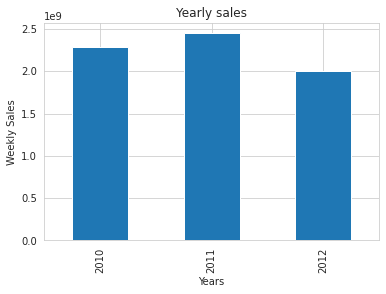

In [128]:
#con este script se pide a python graficar las Ventas Anuales
plt.figure(figsize=(20,8))
df.groupby("Year")[["Weekly_Sales"]].sum().plot(kind='bar',legend=False)
plt.xlabel("Years")
plt.ylabel("Weekly Sales")
plt.title("Yearly sales")
plt.show()

In [129]:
#con este script se pide a Python agrupar por Quarter
group=df.groupby("Quarter").sum("Weekly_Sales")
group.reset_index(level=0, inplace=True)
group["Weekly_Sales"]=(group["Weekly_Sales"])
group

,Quarter,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
0,1,34155,1.494112e+09,135,63690.16,4852.663,254211.116709,11972.575,2986560,3195,10665,22950
1,2,40365,1.826615e+09,0,115643.16,6142.658,300998.893848,14079.416,3529305,8730,33930,27090
2,3,41400,1.841852e+09,135,138977.33,6089.624,309549.329467,14265.976,3619800,14355,58500,28710
3,4,32085,1.574639e+09,180,72060.79,4527.690,239347.624393,11156.570,2804895,15210,63045,22140


<Figure size 1440x576 with 0 Axes>

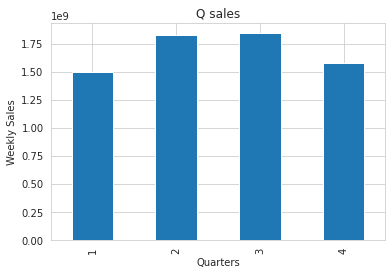

In [130]:
#con este script se pide a python graficar las Ventas by Quarter
plt.figure(figsize=(20,8))
df.groupby("Quarter")[["Weekly_Sales"]].sum().plot(kind='bar',legend=False)
plt.xlabel("Quarters")
plt.ylabel("Weekly Sales")
plt.title("Q sales")
plt.show()

In [131]:
#from pandas.core.groupby.groupby import DataFrame

#con este script se pide a Python realizar la suma y acumulacion por Quarter
#df=DataFrame({'Year', 'Quarter'})
#print(df.groupby(['Year', 'Quarter']).sum().groupby(level=[0]).cumsum())

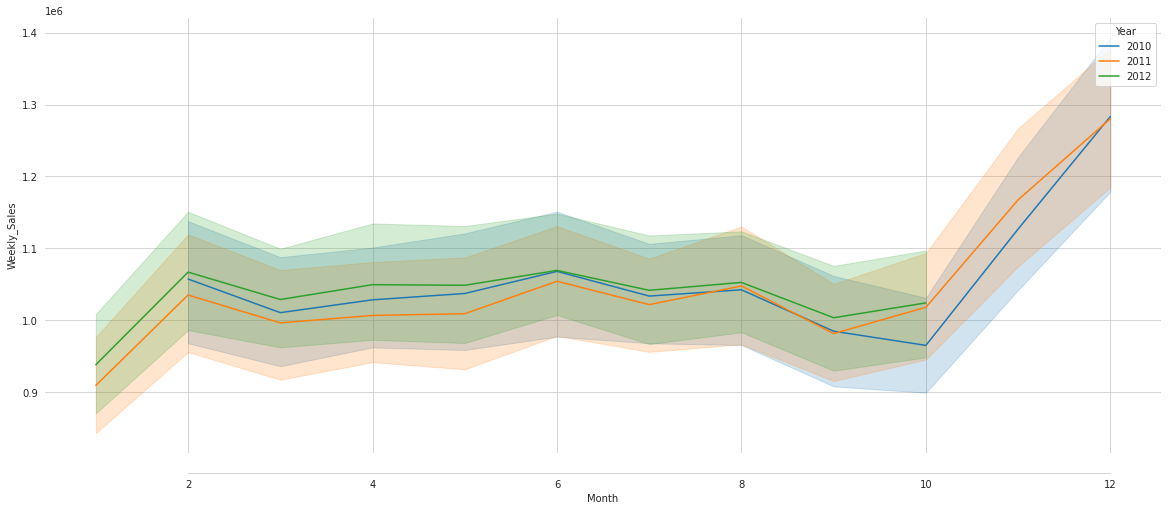

In [132]:
#con este script se pide a Python graficar las ventas por año y por mes
plt.figure(figsize=(20,8))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
sns.set_style('whitegrid')
sns.despine(left=True, offset=20, trim=True)
plt.show()

In [133]:
#con este script se pide a Python ordenar por Store 
df.set_index('Store')

,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
Store,,,,,,,,,,,,
1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,2,5,5
1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,2,6,12
1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,2,7,19
1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,2,8,26
1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,3,9,39,28
45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,4,10,40,5
45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,4,10,41,12


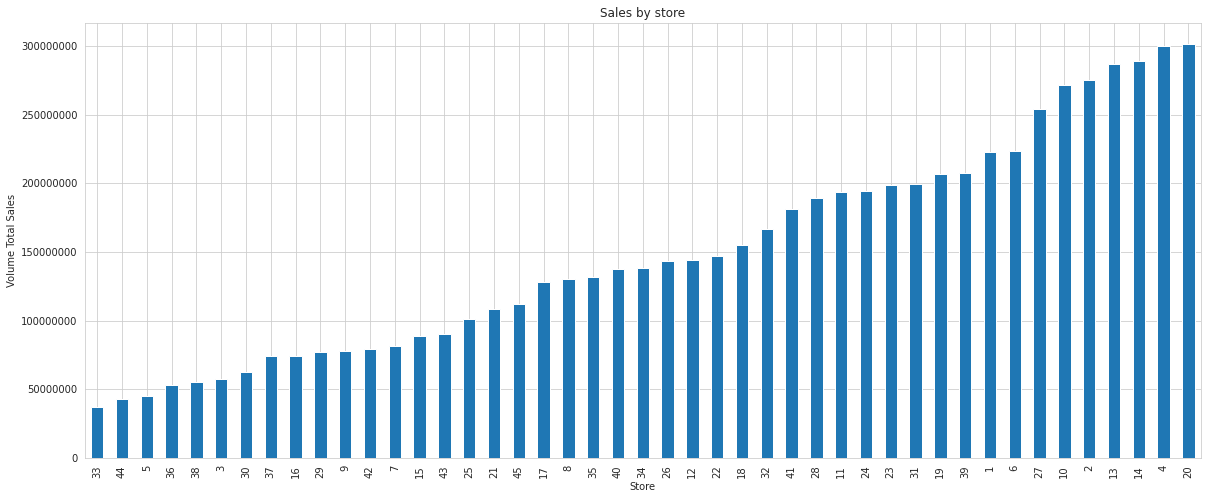

In [134]:
#con este script se pide a Python graficar las ventas por Store
Total_sales= df.groupby('Store')['Weekly_Sales'].sum().sort_values()
Total_sales_array = np.array(Total_sales)
plt.figure(figsize=(20,8))
plt.xticks(rotation=0)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
plt.title('Sales by store')
plt.xlabel('Store')
plt.ylabel('Volume Total Sales')
Total_sales.plot(kind='bar')

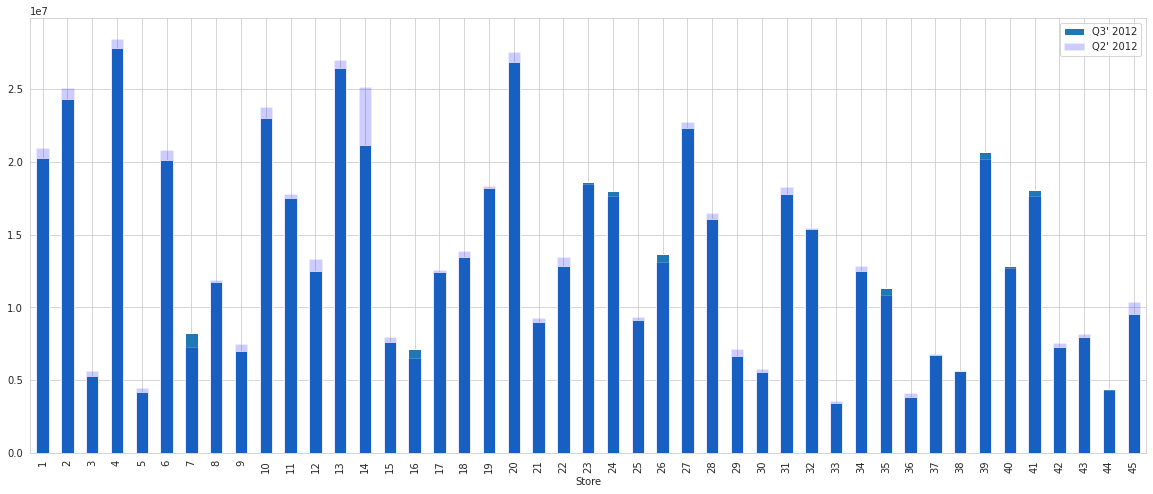

In [135]:
#con este script se agrupan las ventas por el segundo y tercer Q de 2012
Q2_sales = df[(df['Date'] >= '2012-04-01') & (df['Date'] <= '2012-06-30')].groupby('Store')['Weekly_Sales'].sum()
Q3_sales = df[(df['Date'] >= '2012-07-01') & (df['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum()

#con este script se grafica la diferencia en ventas por el segundo y tercer Q
plt.figure(figsize=(20,8))
Q2_sales.plot(ax=Q3_sales.plot(kind ='bar'),kind='bar',color='b',alpha=0.2,legend=True)
plt.legend(["Q3' 2012", "Q2' 2012"])

In [136]:
#en este script se determina el crecimiento entre los Q2 y Q3
Q2_sales= df[(df['Date'] >= '2012-04-01') & (df['Date'] <= '2012-06-30')].groupby('Store')['Weekly_Sales'].sum()
Q3_sales= df[(df['Date'] >= '2012-07-01') & (df['Date'] <= '2012-09-30')].groupby('Store')['Weekly_Sales'].sum()
quarterly_growth_rate = ((Q3_sales - Q2_sales )/Q2_sales)*100
quarterly_growth_rate.sort_values(ascending=False).head()

Store
7     13.330776
16     8.488378
35     4.466637
26     3.955478
39     2.478404
Name: Weekly_Sales, dtype: float64

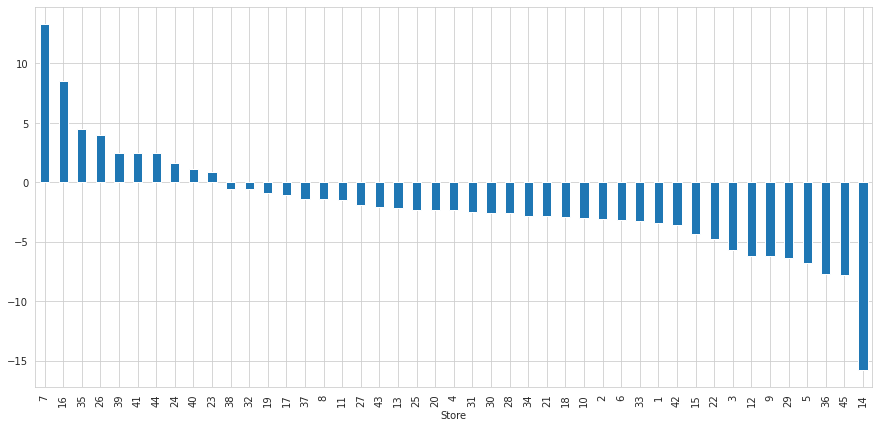

In [137]:
plt.figure(figsize=(15,7))
quarterly_growth_rate.sort_values(ascending=False).plot(kind='bar')

In [138]:
#es este script se solicita a Python calcular la Desviacion Estandar por tienda,
#ordenanda de mayor a menor
Store_devstd = df.groupby('Store')['Weekly_Sales'].std()
Store_devstd = pd.DataFrame(Store_devstd)
Store_devstd=Store_devstd.sort_values('Weekly_Sales', ascending=False)
Store_devstd

,Weekly_Sales
Store,
14,317569.949476
10,302262.062504
20,275900.562742
4,266201.442297
13,265506.995776
23,249788.038068
27,239930.135688
2,237683.694682
39,217466.454833


In [139]:
#con este script Python hace el calculo de la tienda con más desviacion estandar
top_std = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std().sort_values(ascending=False))
top_std.head(1).index[0] , top_std.head(1).Weekly_Sales[top_std.head(1).index[0]] 

(14, 317569.9494755081)

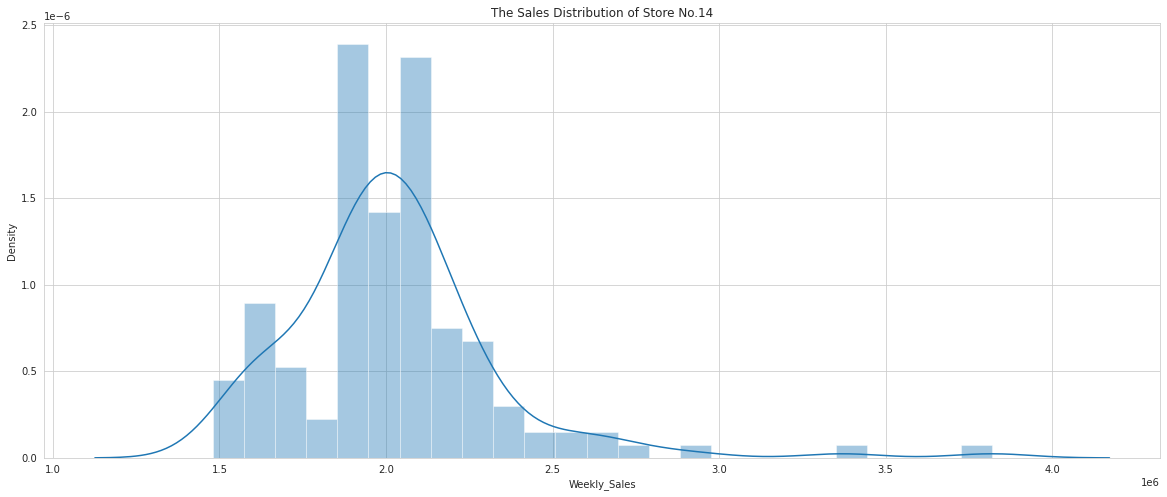

In [140]:
#con este script se pide a Python graficar la DesvStd por tienda
plt.figure(figsize=(20,8))
sns.distplot(df[df['Store'] == top_std.head(1).index[0]]['Weekly_Sales'])
plt.title('The Sales Distribution of Store No.'+ str(top_std.head(1).index[0]))

import warnings
warnings.filterwarnings('ignore')

In [141]:
# con este script se determina el -Coeficiente de Desviación Medio- por tienda el
#se determino dividiendo la DesvStd por tienda entre la media de las tiendas, como sigue coeficiente_DM = Desviación Estandar / media aritmetica * 100
coeficiente_DM = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std() / df.groupby('Store')['Weekly_Sales'].mean()*100)
coeficiente_DM

,Weekly_Sales
Store,
1,10.029212
2,12.342388
3,11.502141
4,12.708254
5,11.866844
6,13.582286
7,19.730469
8,11.695283
9,12.689547


In [142]:
#se pide a Python filtrar los primeros 7 datos 
coef = pd.DataFrame(df.groupby('Store')['Weekly_Sales'].std() / df.groupby('Store')['Weekly_Sales'].mean()*100)
coef = coef.rename(columns={'Weekly_Sales':'Coefficient of standard deviation'})
coef_max = coef.sort_values(by='Coefficient of standard deviation', ascending=False)
coef_max.head(7)

,Coefficient of standard deviation
Store,
35,22.968111
7,19.730469
15,19.338399
29,18.374247
23,17.972115
21,17.029239
45,16.561273


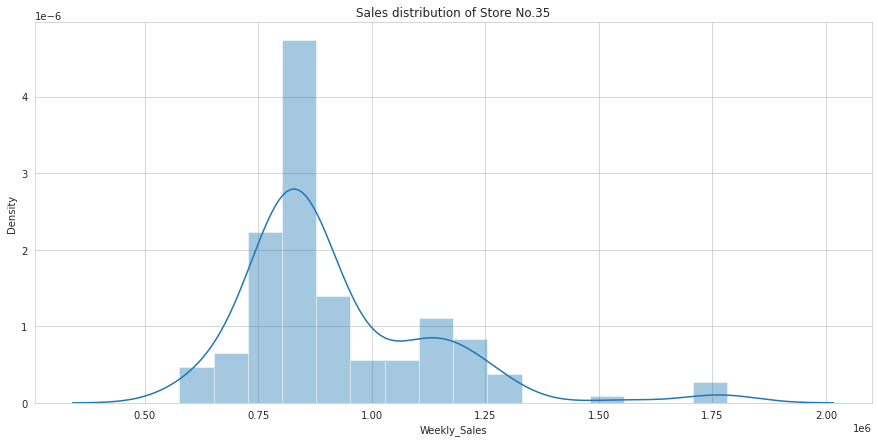

In [143]:
#con este script se pide a Python graficar la distribucion de las Ventas de acuerdo al coeficiente de desviacion standar
plt.figure(figsize=(15,7))
sns.distplot(df[df['Store'] == coef_max.head(1).index[0]]['Weekly_Sales'])
plt.title('Sales distribution of Store No.'+str(coef_max.head(1).index[0]))
import warnings
warnings.filterwarnings('ignore')

In [144]:
#con este script se pide a Python identificar los días festivos
df_Holiday=df[df["Holiday_Flag"]==1]
df_Holiday

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,2,6,12
31,1,2010-09-10,1507460.69,1,78.69,2.565,211.495190,7.787,2010,3,9,36,10
42,1,2010-11-26,1955624.11,1,64.52,2.735,211.748433,7.838,2010,4,11,47,26
47,1,2010-12-31,1367320.01,1,48.43,2.943,211.404932,7.838,2010,4,12,52,31
53,1,2011-02-11,1649614.93,1,36.39,3.022,212.936705,7.742,2011,1,2,6,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6375,45,2011-09-09,746129.56,1,71.48,3.738,186.673738,8.625,2011,3,9,36,9
6386,45,2011-11-25,1170672.94,1,48.71,3.492,188.350400,8.523,2011,4,11,47,25
6391,45,2011-12-30,869403.63,1,37.79,3.389,189.062016,8.523,2011,4,12,52,30
6397,45,2012-02-10,803657.12,1,37.00,3.640,189.707605,8.424,2012,1,2,6,10


In [145]:
#con esta instruccion se definen los Días festivos que encontro Pyton en el dataframe
Super_Bowl =['2010-12-02', '2011-11-02', '2012-10-02']
Labor_Day =  ['2010-10-09', '2011-09-09', '2012-07-09']
Thanksgivig_Day =  ['2010-11-26', '2011-11-25', '2012-11-23']
Xmas = ['2010-12-31', '2011-12-30', '2012-12-28']

In [146]:
#con este script se pide a Python sumar los dias festivos y no festivos
add_days = Super_Bowl + Labor_Day + Thanksgivig_Day + Xmas
add_days
df["Holiday_Flag"] = np.where(df["Holiday_Flag"] == 1, df["Holiday_Flag"], df["Holiday_Flag"].isin(add_days))
df['Holiday_Flag'].value_counts()

0    5985
1     450
Name: Holiday_Flag, dtype: int64

In [147]:
#con esta instruccion se pide a Python determinar la media de ventas de los Dias_Festivos
Sales_Super_Bowl= (pd.DataFrame(df.loc[df.Date.isin(Super_Bowl)]))['Weekly_Sales'].mean()
Sales_Labor_Day = (pd.DataFrame(df.loc[df.Date.isin(Labor_Day)]))['Weekly_Sales'].mean()
Sales_Thanksgivig_Day = (pd.DataFrame(df.loc[df.Date.isin(Thanksgivig_Day)]))['Weekly_Sales'].mean()
Sales_Xmas = (pd.DataFrame(df.loc[df.Date.isin(Xmas)]))['Weekly_Sales'].mean()
{Sales_Super_Bowl, Sales_Labor_Day, Sales_Thanksgivig_Day, Sales_Xmas}

{nan, 960833.1115555555, 1039182.8339999999, 1471273.427777778}

In [148]:
#con esta instruccion se pide a Python determinar la media de ventas de los Dias_No_Festivos
Sales_not_Holiday = df[df['Holiday_Flag'] == 0 ]['Weekly_Sales'].mean()
{Sales_not_Holiday}

{1041256.3802088555}

In [149]:
#con esta instruccion se pide a Python determinar el promedio de ventas 
Average_sales = {'Sales_Super_Bowl' : Sales_Super_Bowl,
                 'Sales_Labor_Day': Sales_Labor_Day,
                 'Sales_Thanksgiving_Day':Sales_Thanksgivig_Day,
                 'Sales_Xmas': Sales_Xmas,
                 'Sales_not_Holiday': Sales_not_Holiday}
Average_sales 

{'Sales_Super_Bowl': nan,
 'Sales_Labor_Day': 1039182.8339999999,
 'Sales_Thanksgiving_Day': 1471273.427777778,
 'Sales_Xmas': 960833.1115555555,
 'Sales_not_Holiday': 1041256.3802088555}

In [150]:
df.groupby('Quarter').sum()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Month,Week,Day
Quarter,,,,,,,,,,,
1,34155,1.494112e+09,135,63690.16,4852.663,254211.116709,11972.575,2986560,3195,10665,22950
2,40365,1.826615e+09,0,115643.16,6142.658,300998.893848,14079.416,3529305,8730,33930,27090
3,41400,1.841852e+09,135,138977.33,6089.624,309549.329467,14265.976,3619800,14355,58500,28710
4,32085,1.574639e+09,180,72060.79,4527.690,239347.624393,11156.570,2804895,15210,63045,22140


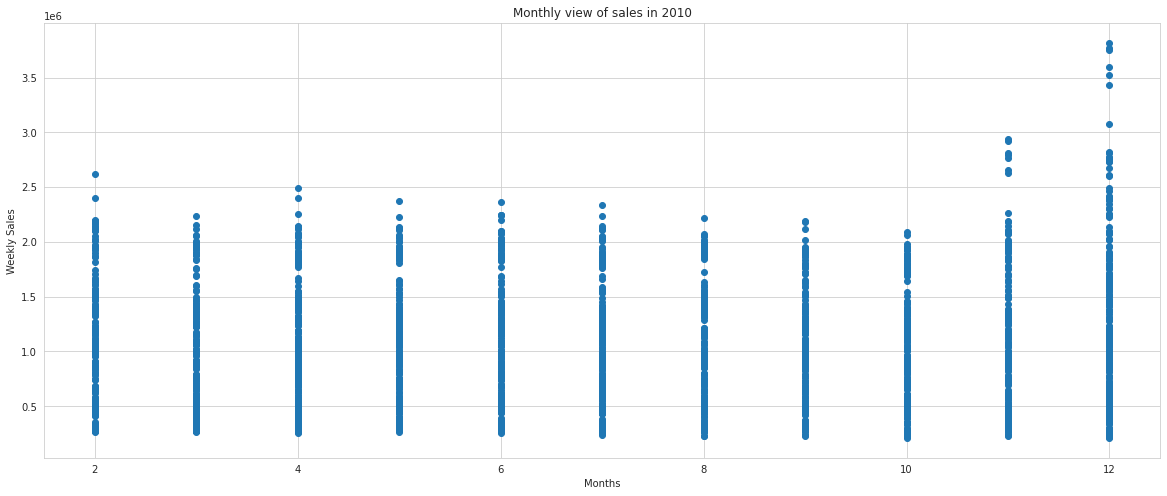

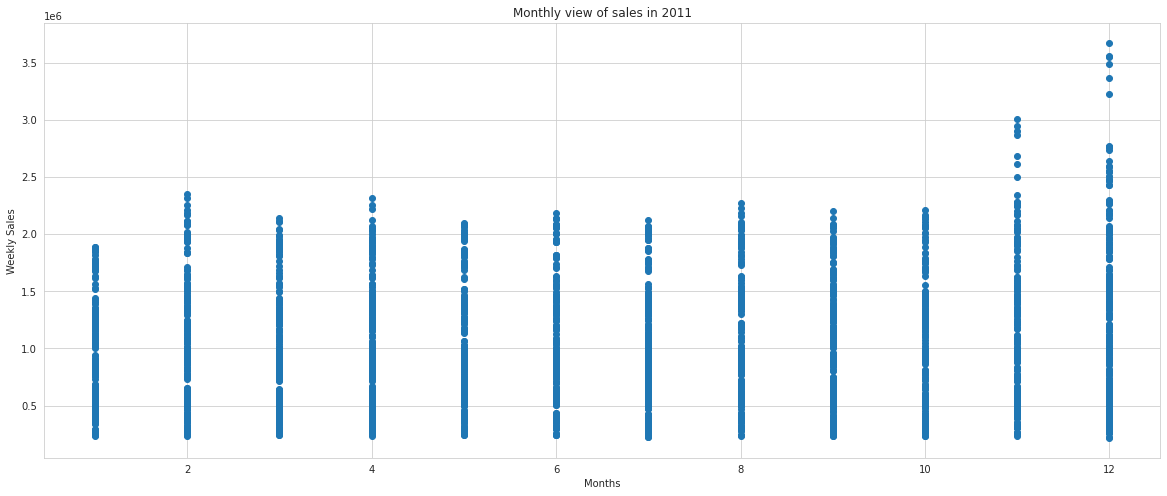

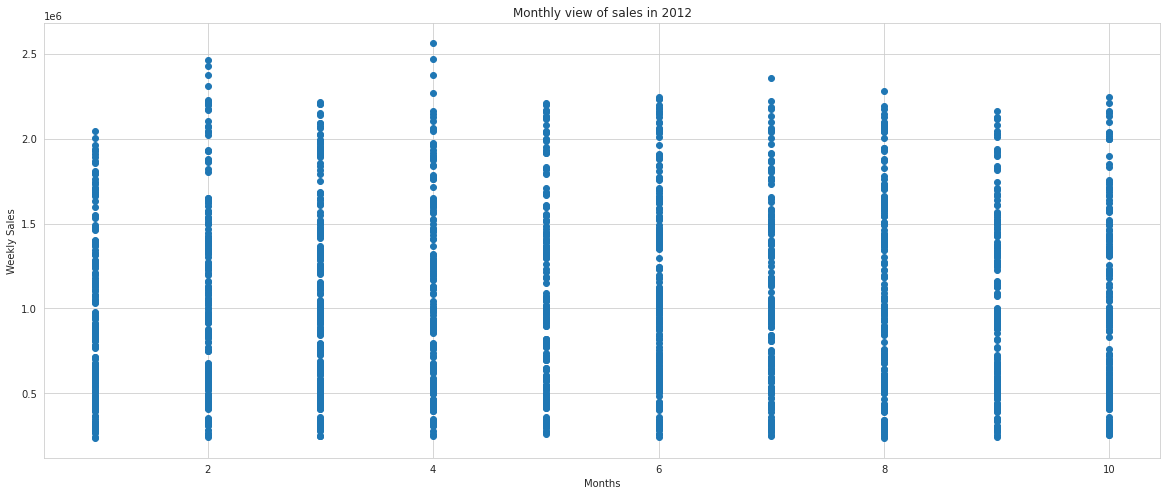

In [151]:
#con este script se pide a Python graficar las Ventas mensuales por cada año 
plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2010]["Month"],df[df.Year==2010]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2010")
plt.show()

plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2011]["Month"],df[df.Year==2011]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2011")
plt.show()

plt.figure(figsize=(20,8))
plt.scatter(df[df.Year==2012]["Month"],df[df.Year==2012]["Weekly_Sales"])
plt.xlabel("Months")
plt.ylabel("Weekly Sales")
plt.title("Monthly view of sales in 2012")
plt.show()

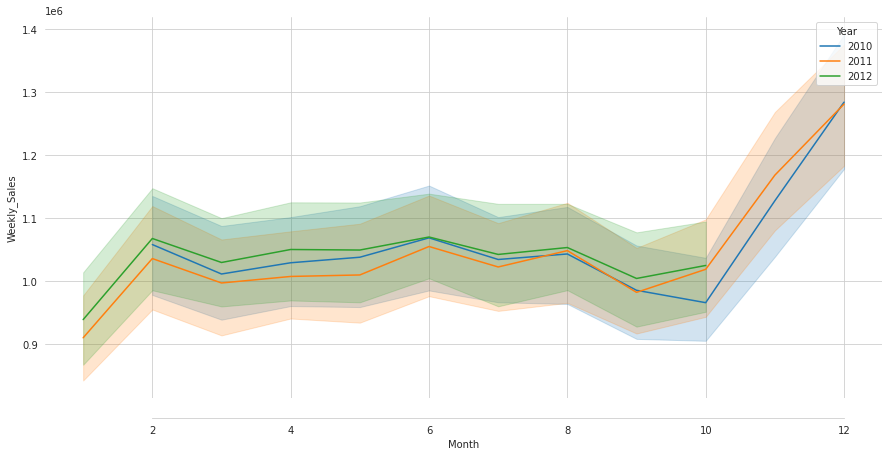

In [152]:
#con esta instrucción se pide a Python graficar las ventas de los tres años de manera mensual
plt.figure(figsize=(15,7))
sns.lineplot(data=df, x='Month', y='Weekly_Sales', hue='Year', palette='tab10')
sns.set_style('whitegrid')
sns.despine(left=True, offset=20, trim=True)
plt.show()

# sección 3. **Quitar Valores de Rango**
en esta sección del codigo se analiza la información para quitar los valores fuera de rango


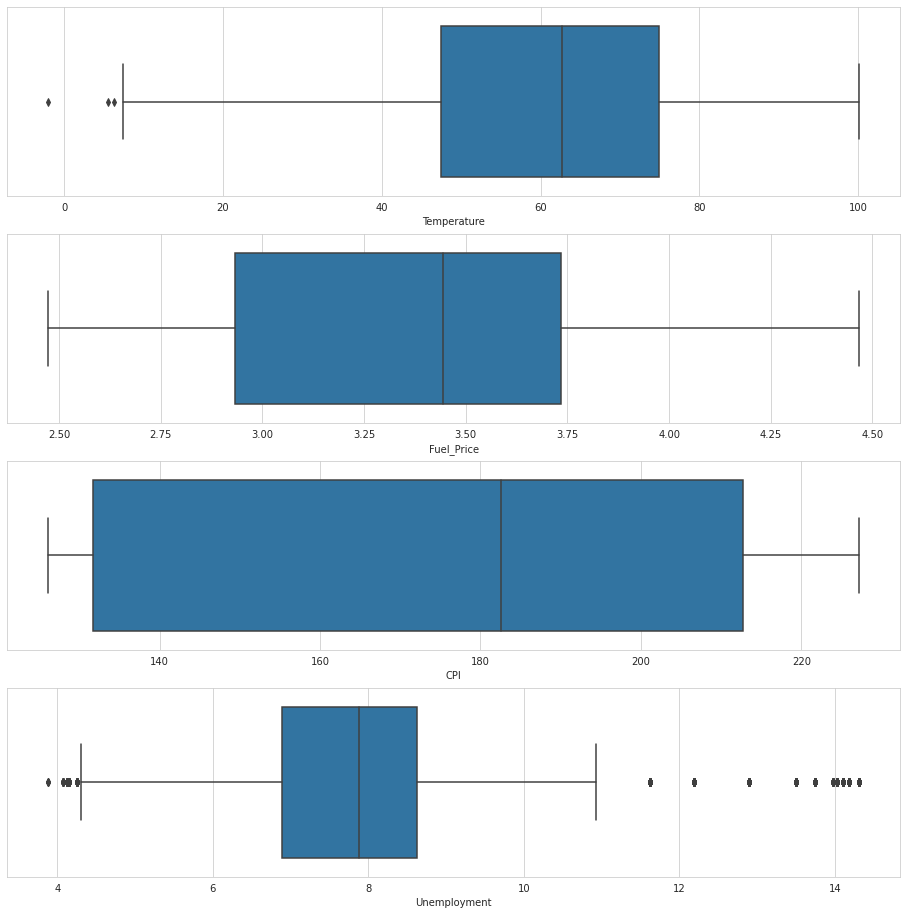

In [153]:
#con este script se grafican y validan los valores atipicos
fig, axis = plt.subplots(4,figsize=(16,16))
X = df[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df[column],ax=axis[i])

import warnings
warnings.filterwarnings('ignore')

In [154]:
df_clean = df[(df['Unemployment']<10) & (df['Unemployment']>4.5) & (df['Temperature']>10)]
df_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,2,5,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,2,6,12
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,2,7,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,2,8,26
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,3,9,39,28
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,4,10,40,5
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,4,10,41,12
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,4,10,42,19


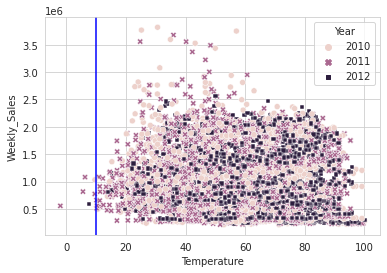

In [155]:
sns.scatterplot(data=df,x='Temperature', y='Weekly_Sales', hue='Year', style='Year')
plt.axvline(x=10,color='b')

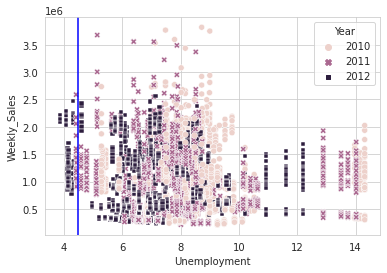

In [156]:
sns.scatterplot(data=df,x='Unemployment', y='Weekly_Sales', hue='Year', style='Year')
plt.axvline(x=4.5,color='b')

In [157]:
#con este script pedimos aPython eliminar los valores atipicos en una nueva función
df_clean = df[(df['Unemployment']<10) & (df['Unemployment']>4.5) & (df['Temperature']>10)]
df_clean


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2010,1,2,5,5
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2010,1,2,6,12
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2010,1,2,7,19
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2010,1,2,8,26
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,2010,1,3,9,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6430,45,2012-09-28,713173.95,0,64.88,3.997,192.013558,8.684,2012,3,9,39,28
6431,45,2012-10-05,733455.07,0,64.89,3.985,192.170412,8.667,2012,4,10,40,5
6432,45,2012-10-12,734464.36,0,54.47,4.000,192.327265,8.667,2012,4,10,41,12
6433,45,2012-10-19,718125.53,0,56.47,3.969,192.330854,8.667,2012,4,10,42,19


In [158]:
Q1 = df[['Temperature']].quantile(0.25)
print('Lower_limit_t', Q1)
Q3 = df[['Temperature']].quantile(0.75)
print('Upper_limit_t', Q3)

IQR = Q3 - Q1


Lower_limit_t Temperature    47.46
Name: 0.25, dtype: float64
Upper_limit_t Temperature    74.94
Name: 0.75, dtype: float64


In [159]:
Lower_limit_t=(Q1-1.5 * IQR)
print(Lower_limit_t)

Upper_limit_t=(Q1+1.5 * IQR)
print(Upper_limit_t)


Temperature    6.24
dtype: float64
Temperature    88.68
dtype: float64


In [160]:
Q1 = df[['Unemployment']].quantile(0.25)
print('Lower_limit_U', Q1)
Q3 = df[['Unemployment']].quantile(0.75)
print('Upper_limit_U', Q3)

Lower_limit_U Unemployment    6.891
Name: 0.25, dtype: float64
Upper_limit_U Unemployment    8.622
Name: 0.75, dtype: float64


In [161]:
Lower_limit_U=(Q1-1.5 * IQR)
print(Lower_limit_U)

Upper_limit_U=(Q1+1.5 * IQR)
print(Upper_limit_U)

Temperature    NaN
Unemployment   NaN
dtype: float64
Temperature    NaN
Unemployment   NaN
dtype: float64


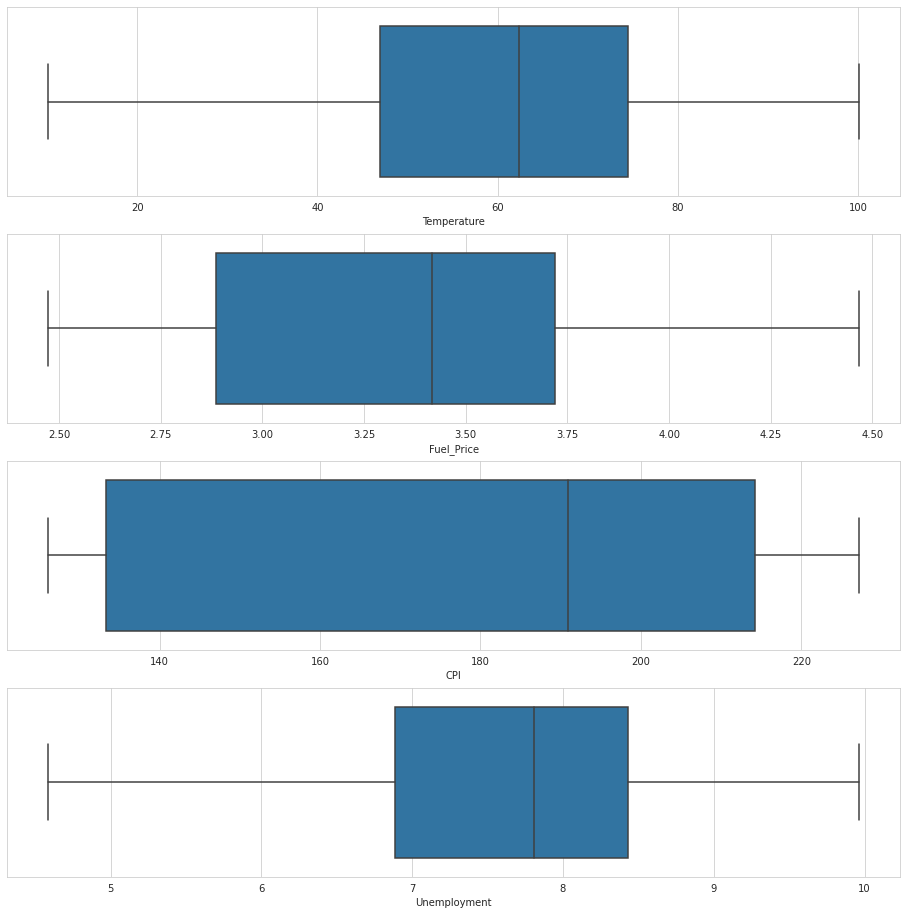

In [162]:
#se validan los datos de los outliers
fig, axis = plt.subplots(4,figsize=(16,16))
X = df_clean[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_clean[column], ax=axis[i])

import warnings
warnings.filterwarnings('ignore')

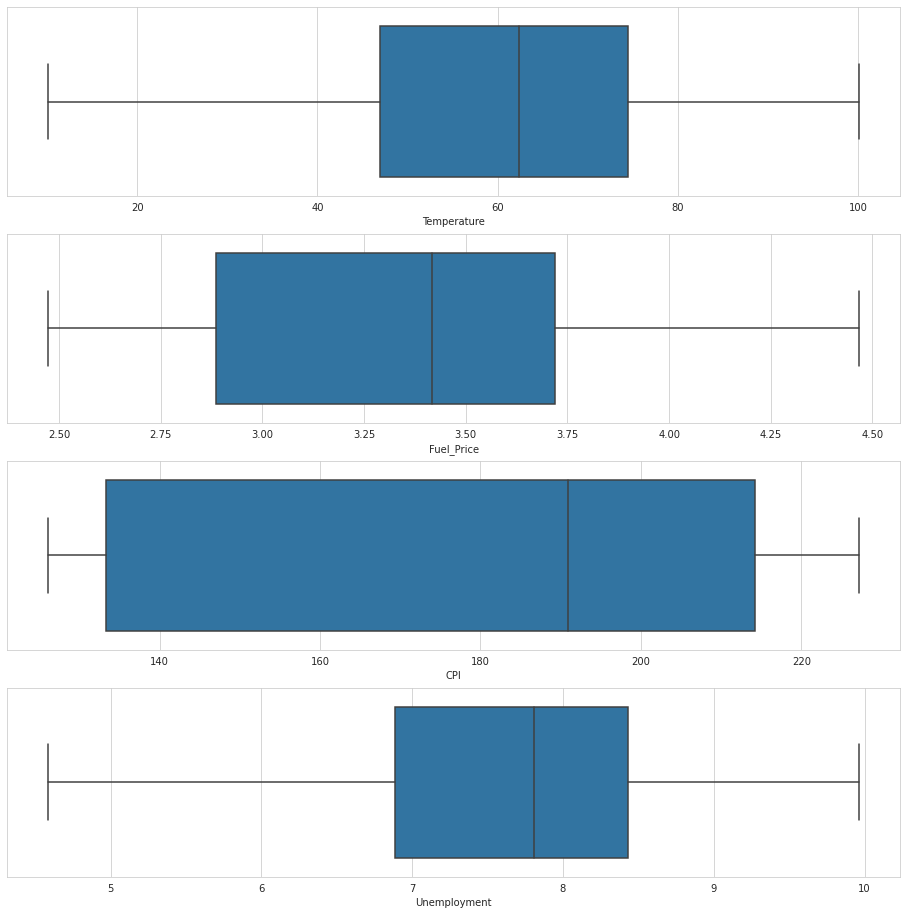

In [163]:
# Verificamos ya no tener valores atipicos
fig, axis = plt.subplots(4,figsize=(16,16))
X = df_clean[['Temperature','Fuel_Price','CPI','Unemployment']]
for i,column in enumerate(X):
    sns.boxplot(df_clean[column],ax=axis[i])


In [164]:
#con este script se pide a Python calcular la correlacion entre variables
df.corr()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Year,Quarter,Month,Week,Day
Store,1.000000e+00,-0.335332,-4.386841e-16,-0.022659,0.060023,-0.209492,0.223531,3.474318e-12,5.034745e-16,2.910676e-15,3.106283e-15,1.478526e-15
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176,-1.837754e-02,6.336275e-02,7.614332e-02,7.421127e-02,-1.740946e-02
Holiday_Flag,-4.386841e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960,-5.678257e-02,8.136344e-02,1.229958e-01,1.277427e-01,4.452608e-02
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158,6.426923e-02,2.444967e-01,2.358618e-01,2.361833e-01,2.697332e-02
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684,7.794703e-01,-4.307778e-02,-4.215590e-02,-3.240300e-02,2.807253e-02
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020,7.479573e-02,4.733426e-03,4.979672e-03,6.041530e-03,2.684300e-03
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000,-2.418135e-01,-1.787284e-02,-1.274559e-02,-1.589158e-02,-4.233293e-03
Year,3.474318e-12,-0.018378,-5.678257e-02,0.064269,0.779470,0.074796,-0.241813,1.000000e+00,-1.852383e-01,-1.944645e-01,-1.819189e-01,6.405867e-03
Quarter,5.034745e-16,0.063363,8.136344e-02,0.244497,-0.043078,0.004733,-0.017873,-1.852383e-01,1.000000e+00,9.670705e-01,9.638699e-01,2.254160e-02
Month,2.910676e-15,0.076143,1.229958e-01,0.235862,-0.042156,0.004980,-0.012746,-1.944645e-01,9.670705e-01,1.000000e+00,9.959843e-01,1.519184e-02


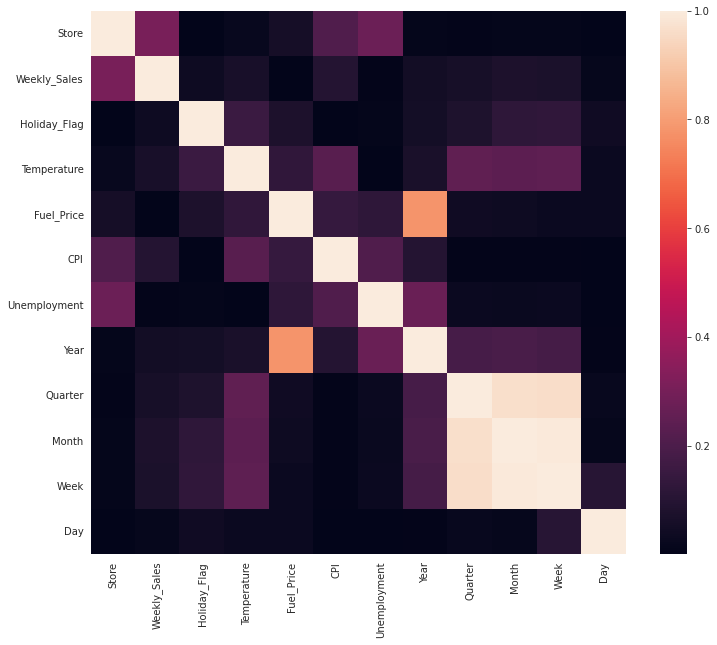

In [165]:
#con este grafico de calor podemos ver las correlaciones de las diferentes columnas, entre mas oscuro mas correlacion existe
plt.figure(figsize = (12,10))
sns.heatmap(df_clean.corr().abs())    

plt.show()

In [166]:
#sns.pairplot(df.drop('Store', axis=1))

# sección 4. **Modelos y Pronostico**

en esta sección del codigo se procede a realizar el modelado de la información

 **ARIMA**

In [167]:
df_arima = df[df["Store"]==15]
df_arima = df_arima[['Date', 'Weekly_Sales']]
df_arima.set_index('Date', inplace =True)
df_arima

,Weekly_Sales
Date,
2010-02-05,652122.44
2010-02-12,682447.10
2010-02-19,660838.75
2010-02-26,564883.20
2010-03-05,605325.43
...,...
2012-09-28,553901.97
2012-10-05,573498.64
2012-10-12,551799.63


In [168]:
df_train = df_arima.iloc[:122]
df_test = df_arima.iloc[-20:]

In [169]:
df_test

,Weekly_Sales
Date,
2012-06-15,636737.65
2012-06-22,687085.60
2012-06-29,624099.48
2012-07-06,678024.75
2012-07-13,591335.50
2012-07-20,592369.22
2012-07-27,571190.83
2012-08-03,590739.62
2012-08-10,590453.63


In [170]:
from statsmodels.tsa.arima.model import ARIMA

In [222]:
Inicio = len(df_train)
Final = len(df_train) + len(df_test) + 30

In [223]:
modelo_arima = ARIMA(df_train, order=(52,0,0))
modelo_arimadef = modelo_arima.fit()

Arima_predict = modelo_arimadef.predict(start=Inicio, end=Final, typ='levels')

In [224]:
Arima_predict

2012-06-08    6.439443e+05
2012-06-15    6.417542e+05
2012-06-22    6.822151e+05
2012-06-29    6.433938e+05
2012-07-06    6.300937e+05
2012-07-13    6.596248e+05
2012-07-20    6.179299e+05
2012-07-27    5.981636e+05
2012-08-03    6.029547e+05
2012-08-10    5.599771e+05
2012-08-17    6.308710e+05
2012-08-24    5.881313e+05
2012-08-31    6.669164e+05
2012-09-07    6.371392e+05
2012-09-14    5.408024e+05
2012-09-21    5.529293e+05
2012-09-28    4.924743e+05
2012-10-05    5.732520e+05
2012-10-12    5.623465e+05
2012-10-19    5.889570e+05
2012-10-26    6.204377e+05
2012-11-02    6.115453e+05
2012-11-09    5.954611e+05
2012-11-16    5.828329e+05
2012-11-23    1.061484e+06
2012-11-30    6.975014e+05
2012-12-07    7.574472e+05
2012-12-14    8.194512e+05
2012-12-21    1.143236e+06
2012-12-28    6.727077e+05
2013-01-04    5.425497e+05
2013-01-11    4.928609e+05
2013-01-18    4.910560e+05
2013-01-25    4.237655e+05
2013-02-01    4.977795e+05
2013-02-08    5.864200e+05
2013-02-15    6.150688e+05
2

In [225]:
df_predict=pd.DataFrame(Arima_predict)

In [226]:
df_predict

,predicted_mean
2012-06-08,6.439443e+05
2012-06-15,6.417542e+05
2012-06-22,6.822151e+05
2012-06-29,6.433938e+05
2012-07-06,6.300937e+05
2012-07-13,6.596248e+05
2012-07-20,6.179299e+05
2012-07-27,5.981636e+05
2012-08-03,6.029547e+05
2012-08-10,5.599771e+05


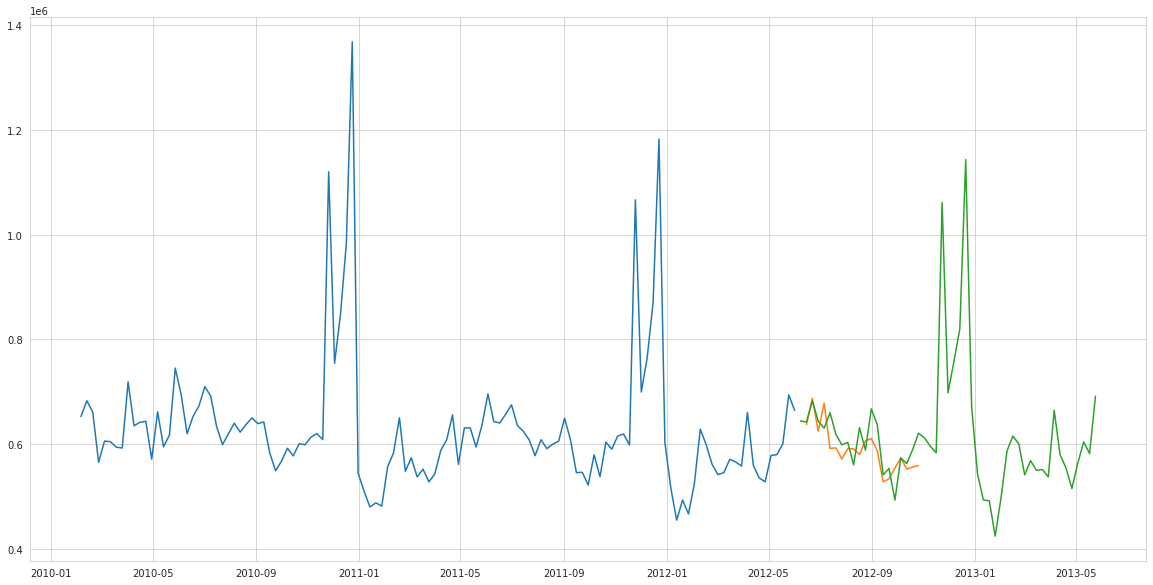

In [227]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(df_train)
plt.plot(df_test)
plt.plot(df_predict)

In [228]:
#con este script Python extrae el año directamente de la columna 'Date' y lo pone columna con ese nombre
#df['Month'] = pd.DatetimeIndex(df['Date']).year
#df

KeyError: ignored

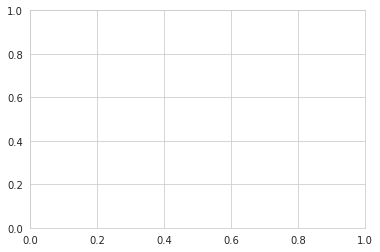

In [229]:
fig, ax = plt.subplots()

ax.plot(df['Weekly_Sales'], df['Store'])
ax.set_xlabel('Date')
ax.set_ylabel('Weekly_Sales')
ax.axvspan(10, 13, color='#808080', alpha=0.2)

plt.xticks(np.arange(0, 13, 8), [2010, 2011, 2012])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
#con este cript se indica a Python entrenar y probar los ultimos 12 registros
train = df[:-12]
test = df[-12:]

In [ ]:
#con este script se indica calcular la media historica de las ventas
Sales_not_holiday_mean = np.mean(train['Weekly_Sales'])
Sales_not_holiday_mean

In [ ]:
#con este script se pide a Python predecir la media de ventas historicas 
test.loc[:, 'pred_mean'] = Sales_not_holiday_mean
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#con el script se calcula [ mean absolute percentage error] (MAPE) el cual es un %
mape_hist_mean = mape(test['Weekly_Sales'], test['pred_mean'])
print(mape_hist_mean)

In [ ]:
fig, ax = plt.subplots()
ax.plot(train['Date'], train['Weekly_Sales'], 'g-.', label='Train')
ax.plot(test['Date'], test['Weekly_Sales'], 'b-', label='Test')
ax.plot(test['Date'], test['pred_mean'], 'r--', label='Predicted')
ax.set_xlabel('Year')
ax.set_ylabel('Weekly_Sales')
ax.axvspan(10, 13, color='#808080', alpha=0.2)
ax.legend(loc=2)
plt.xticks(np.arange(0, 13, 24), [2010, 2011, 2012])
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
#con este script se calcula la media de las ventas del last year
last_year_mean = np.mean(train['Weekly_Sales'][-12:])
last_year_mean

In [ ]:
#con este script se determina la media de ventas
test.loc[:, 'pred__last_yr_mean'] = last_year_mean
test

In [ ]:
last = train.Weekly_Sales.iloc[-1]
print(last)

In [ ]:
test.loc[:, 'pred_last'] = last

In [ ]:
mape_last = mape(test['Weekly_Sales'], test['pred_last'])
print(mape_last)

In [ ]:
test.loc[:, 'pred_last_season'] = train['Weekly_Sales'][-12:].values

In [ ]:
mape_naive_seasonal = mape(test['Weekly_Sales'], test['pred_last_season'])
print(mape_naive_seasonal)

In [ ]:
#con este script se grafican las metricas determinadas

#fig, ax = plt.subplots()

#x = ['hist_mean', 'last_year_mean', 'last', 'naive_seasonal']
#y = [43.59, 43.59, 1.88, 8.74]

#ax.bar(x, y, width=0.4)
#ax.set_xlabel('Baselines')
#ax.set_ylabel('MAPE (%)')
#ax.set_ylim(0, 75)

#for index, value in enumerate(y):
#    plt.text(x=index, y=value + 1, s=str(value), ha='center')

#plt.tight_layout()

In [ ]:
#se pide a Python generar 1000 muestras para definir el ruido
np.random.seed(42)
steps = np.random.standard_normal(1000)
steps[0]=0
random_walk = np.cumsum(steps)

In [ ]:
#se grafican las muestras del ruido en los datos con una distribucion norma de 0 a 1
fig, ax = plt.subplots()
ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

In [ ]:
#con este script se determina si la serie es estacional o no de acuerdo con el ADF test se determin que la seri es estacional debido a que va de -1 a 1
ADF_result = adfuller(random_walk)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

In [ ]:
#con es script se determina la funcion de autocorrelacion
plot_acf(random_walk, lags=20);

In [ ]:
diff_random_walk = np.diff(random_walk, n=1)

In [ ]:
#se asigna el random walk a los 12 meses y, se entrena el 80% de los datos y se prueba el 20%
ADF_result = adfuller(diff_random_walk)
train = df[:36]
test = df[12:]

In [ ]:
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

In [ ]:
plot_acf(diff_random_walk, lags=20);

**Analisis ANOVA**

In [ ]:
from scipy import stats
x=['Holiday_Flag']
y=['Weekly_Sales']
stats.kruskal(x,y)

In [ ]:
x=df[df['Holiday_Flag'] == 0]['Weekly_Sales']
y=df[df['Holiday_Flag'] == 1]['Weekly_Sales']
stats.kruskal(x,y)

In [ ]:
df.groupby(['Weekly_Sales'])['Holiday_Flag'].mean()

In [ ]:
#se calcula el p_value determinando que los holiday si afectan las ventas, por lo tanto en los Holiday las ventas incrementan
from scipy.stats import f_oneway
f_oneway(x,y)

**Linear Regression**

In [ ]:
#con este script se calcula la regresion lineal or linear Regression :
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
X = df_clean[['Store','Fuel_Price','CPI','Unemployment','Day','Month','Year']]
Y = df_clean['Weekly_Sales']
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2)

In [ ]:
print('Linear Regression:')
print()
reg = LinearRegression()
reg.fit(X_train, Y_train)
Y_pred = reg.predict(X_test)
print('Accuracy:',reg.score(X_train, Y_train)*100)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
sns.scatterplot(Y_pred, Y_test)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#se calcula el random forest regressor
from sklearn.ensemble import RandomForestRegressor
print('Random Forest Regressor:')
print()
rfr = RandomForestRegressor()        
rfr.fit(X_train,Y_train)
Y_pred = rfr.predict(X_test)
print('Accuracy:',rfr.score(X_test, Y_test)*100)
print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
sns.scatterplot(Y_pred, Y_test)


import warnings
warnings.filterwarnings('ignore')

In [ ]:
#con este script se solicita a Python calcular el analsis de variaza entre 'Holiday_ Flag' vs 'Weekly_Sales', el modelo indica que la variacion
#afecta las ventas de manera significativa

model = smf.ols ('Holiday_Flag ~ Weekly_Sales', data = df).fit()
aov_table = anova_lm(model, type=2)
anova_result = sm.stats.anova_lm(model, type=2)
print(aov_table)

In [ ]:
import prophet as ppt

In [ ]:
import scipy.stats as stats
from pmdarima import auto_arima

In [ ]:
df = train.loc[(train.Store == 1),['Date','Weekly_Sales']]
print('Earliest date: %s; Latest date: %s' % (df['Date'].min(), df['Date'].max()))

In [ ]:
df.set_index('Date', inplace=True)

In [ ]:
df.groupby('Date')

In [ ]:
df.plot(figsize=(15, 6),title="Walmart Sales in One Department of One Store Feb 2010 to Oct 2012")

In [ ]:
df.index = pd.to_datetime(df.index)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

advanced_decomposition = STL(df.Weekly_Sales, period=52).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True)

ax1.plot(advanced_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(advanced_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(advanced_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(advanced_decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 12, 12), [2010, 2011, 2012])

fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
from pmdarima import auto_arima
stepwise_model = auto_arima(df, start_p=1, d=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
print(stepwise_model.aic())

In [ ]:
train = df.loc[:'2012-05-01']
test = df.loc['2012-05-01':]
stepwise_model.fit(train)

In [ ]:
from statsmodels.tsa.arima_model import ARMA

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)

In [ ]:
ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [ ]:
future_forecast = stepwise_model.predict(n_periods=len(test))

In [ ]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot()

In [ ]:
d.concat([df,future_forecast],axis=1).plot(figsize=(15, 6),
                                             title="Walmart Sales in One Department of One Store Feb 2010 to Oct 2012")

In [ ]:
df_arima=df
df_arima=df_arima.set_index('Date')

In [ ]:
plt.figure(figsize=(20,9))
df_arima['Weekly_Sales'].plot()
plt.show()

In [ ]:
df_arimamonth = df_arima.resample('M').mean()

In [ ]:
plt.figure(figsize=(20,8))
df_arimamonth['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

In [ ]:
train_data = df_arimamonth[:int(0.7*(len(df_arimamonth)))] 
test_data = df_arimamonth[int(0.7*(len(df_arimamonth))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

In [ ]:
train_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [ ]:
from pmdarima.arima import ADFTest
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff (df_arimamonth['Weekly_Sales'])

In [ ]:
model_auto_arima = auto_arima(train_data['Weekly_Sales'], trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=0, max_D=0,
                  error_action='ignore',approximation = False)
model_auto_arima.fit(train_data['Weekly_Sales'])

In [ ]:
model_auto_arima.summary()

In [ ]:
#y_pred = model_auto_arima.predict(n_periods=len(test_data['Weekly_Sales']))
#y_pred = pd.DataFrame(y_pred,index = test_data['Weekly_Sales'].index,columns=['Prediction'])
#plt.figure(figsize=(20,6))
#plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
#plt.plot(train_data['Weekly_Sales'], label='Train')
#plt.plot(test_data['Weekly_Sales'], label='Test')
#plt.plot(y_pred, label='Prediction of ARIMA')
#plt.legend(loc='best')
#plt.xlabel('Date', fontsize=14)
#plt.ylabel('Weekly Sales', fontsize=14)
#plt.show()

In [ ]:
#con este escript se elige el tipo de modelo

#import statsmodels as sm
#from statsmodels.tsa.arima_model import ARIMA
#from statsmodels.tsa.stattools import adfuller
#def test_stationarity(timeseries):

#estadisticas en la determinación de la media móvil y la desviación estandar
#  rolmean = pd.rolling_mean(timeseries, window=12)
#  rolstd = pd.rolling_std(timeseries, window=12)

#graficar las estadisticas
#  orig = plt.plot(timeseries, color="blue", label="Original")
#  mean = plt.plot(rolmean, color="red", label="Media Movil")
#  std = plt.plot(rolstd, color="black", label="Desviacon Estandar")
#  plt.legend(loc="best")
#  plt.title("Media Movil y Desviacion Estandar")
#  plt.show(block=False)

#calculo de la media movil
#moving_avg = pd.rolling_mean(datos["Weekly_Sales"], 12)
#datos["Weekly_Sales"]

#grafica de la media movil
#moving_avg.plot(label="Media Movil", color="red")
#plt.legend(loc="best")

#from statsmodels.tsa.stattools import adfuller
#def test_stationarity(timeseries):
    #determine rolling statistics
#    rolmean = pd.Series(timeseries).rolling(window=24).mean()#24 hours on each day
#    rolstd = pd.Series(timeseries).rolling(window=24).std()
#    #plot rolling statistics
#    orig = plt.plot(timeseries,color = 'blue',label='original')
#    mean = plt.plot(rolmean,color = 'red',label = 'rolling mean')
#    std = plt.plot(rolstd,color = 'black',label = 'rolling std')
#    plt.legend(loc = 'best')
#    plt.title('rolling mean and standard deviation')
#    plt.show(block = False)

   #perform dickey fuller test
#    print('result of dickey fuller test:')
#    dftest = adfuller(timeseries,autolag = 'AIC')
#    dfoutput = pd.Series(dftest[0:4],index = ['Test statistics', 'p-value', '#lags used', 'number of observation used'])
#    for key,value in dftest[4].items():
#        dfoutput['critical value (%s)'%key] = value
#    print(dfoutput)

#from matplotlib.pylab import rcParams
#rcParams['figure.figsize'] = 20,10
#test_stationarity(train_original['Count'])


In [ ]:
#df = px.data.gapminder()
#Weekly_Sales = df.query("Weekly_Sales")

#for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
#    fig = px.scatter(Weekly_Sales,
#                     x="gdpPercap", y="lifeExp", size="pop", color="continent",
#                     log_x=True, size_max=60,
#                     template=template, title="Gapminder 2007: '%s' theme" % template)
#    fig.show()

#df = px.data.gapminder()
#df_2007 = df.query("year==2007")

#for template in ["plotly", "plotly_white", "plotly_dark", "ggplot2", "seaborn", "simple_white", "none"]:
#    fig = px.scatter(df_2007,
#                     x="gdpPercap", y="lifeExp", size="pop", color="continent",
#                     log_x=True, size_max=60,
#                     template=template, title="Gapminder 2007: '%s' theme" % template)
#    fig.show()

In [ ]:
#f.["Temperature"].plot(figsize=(20,8))

#df.plot()

In [ ]:
#plt.plot(test)

#train = df_clean['Weekly_Sales']
#test = df_clean['Weekly_Sales']
#plt.plot(train)
#plt.plot(test)

In [ ]:
#plt.figure(figsize=(50,6))
#df_clean['Weekly_Sales'].plot()

In [ ]:
#model_auto_arima = auto_arima(train_data_diff, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
#                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
#                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
#                  error_action='ignore',approximation = False)
#model_auto_arima.fit(train_data_diff)

In [ ]:
#X = df_clean[['Store','Fuel_Price','CPI','Unemployment','Day','Month','Year']]
#y = df_clean['Weekly_Sales']

In [ ]:
#from sklearn.model_selection import train_test_split
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 100)

In [ ]:
#from sklearn.linear_model import LinearRegression

#model = LinearRegression()
#model.fit(X_train,y_train)